In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
import torch

import numpy as np
import pandas as pd
from osgeo import gdal as GD
import matplotlib.pyplot as mplot
from matplotlib.image import imread

from scipy import stats

# Add your TIF files

Don't forget to connect your google drive and with the copy of the tif files.

<img src="https://lh3.google.com/u/0/d/1LIyz7sjoeISY4rQDWGXm9cpIlBu6H3Yy=w3360-h1942-iv1" width="300">

### (Deprecated)Files:

1. [slope.tif](https://drive.google.com/file/d/1MfTlLTyqyfSOtk__-cUpAFh6Ybe57fdr/view?usp=share_link)
2. [elevation.tif](https://drive.google.com/file/d/1jgfw_IeEIeXx7M9Z1v87rSqV3yZO87Hl/view?usp=share_link)
3. [fire.tif](https://drive.google.com/file/d/1VrEPM7JFtEoDxgQnbqZyB69zBElsj_Bh/view?usp=share_link)


### New Files in the folder below:

1. [LANDFIRE DATA](https://drive.google.com/drive/folders/1UbXTCPJIEq0k4rHnDJLWi5LvwA5I7C2E?usp=sharing)


In [ ]:
# No need to run this, if google drive is already connected.
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load TIF files

In [ ]:
slope = GD.Open(r'/content/drive/My Drive/LANDFIRE DATA/LC20_SlpP_220.tif')
elevation = GD.Open(r'/content/drive/My Drive/LANDFIRE DATA/LC20_Elev_220.tif')
fire = GD.Open(r'/content/drive/My Drive/LANDFIRE DATA/us_105pms.tif')

# Number of bands in the raster layer
print("Bands in the slope layer: ",slope.RasterCount)
print("Bands in the elevation layer: ",elevation.RasterCount)
print("Bands in the fire layer: ",fire.RasterCount)

Bands in the slope layer:  1
Bands in the elevation layer:  1
Bands in the fire layer:  1


# Implementing a z-score standardisation

Formula:

$ y_i =\frac{ x_i - \bar{x} }{s} $


Where $\bar{x}$ is the mean and the $s$ is the standard deviation.


Size of each "layer"


```python
np.array(slope.GetRasterBand(1).ReadAsArray()).shape
```

(rows, columns) = (24622, 14944)


In [ ]:
# slopeArray = stats.zscore( np.array(slope.GetRasterBand(1).ReadAsArray()))
# elevationArray = stats.zscore( np.array(elevation.GetRasterBand(1).ReadAsArray()))
# fireArray = stats.zscore( np.array(elevation.GetRasterBand(1).ReadAsArray()))

## TIF printing
To view the image in matplotlib use the code below:




In [ ]:
# mplot.imshow(imread(" <add file path here> "))
# mplot.axis("off")
# mplot.show()

# Cropping TIF files

## GDAL (not working)

Cropping the large tif file into smaller `224x224` images.

In [ ]:
# def crop_tiff(input_tif, output_tif, x_offset, y_offset, x_size, y_size):
#     # Get the required size and offset of the cropped image
#     x_offset, y_offset, x_size, y_size = int(x_offset), int(y_offset), int(x_size), int(y_size)

#     # Create a new TIFF file for the cropped image
#     output = GD.Translate(output_tif, input_tif, format='GTiff', width=x_size, height=y_size, projWin=[x_offset, y_offset, x_offset + x_size, y_offset + y_size])

#     return output

In [ ]:
# output_tif = "cropped.tif"
# crop_tiff(slope, output_tif, x_offset=0, y_offset=0, x_size=224, y_size=224)

# Splicing numpy array into smaller 2D arrays

In [ ]:
# fireArray.shape

In [ ]:
print( "rows:", int( 8780 / 224 ) )
print( "columns:", int( 6796 / 224 ) )

rows: 39
columns: 30


In [ ]:
# print( "rows", int( 24622 / 224 ) )
# print( "columns", int( 14944 / 224 ) )

Whichever from rows and columns is are smaller, we will use it's length for cropping below.

In [ ]:
slopeArray = np.array(slope.GetRasterBand(1).ReadAsArray())
elevationArray = np.array(elevation.GetRasterBand(1).ReadAsArray())
fireArray = np.array(fire.GetRasterBand(1).ReadAsArray())

In [ ]:
# slope.shape

In [ ]:
croppedSlopeArrays = []
croppedElevationArrays = []
croppedFireArrays = []
for i in range(0,30):
  croppedSlopeArrays.append(slopeArray[i*224:(i+1)*224,i*224:(i+1)*224])
  croppedElevationArrays.append(elevationArray[i*224:(i+1)*224,i*224:(i+1)*224])
  croppedFireArrays.append(fireArray[i*224:(i+1)*224,i*224:(i+1)*224])
  # print(croppedSlopeArrays[i].shape) Used to check if the shape of each array was 224

croppedSlopeArrays = np.array(croppedSlopeArrays)
croppedElevationArrays = np.array(croppedElevationArrays)
croppedFireArrays = np.array(croppedFireArrays)

In [ ]:
halfWayPoint = int(croppedElevationArrays.shape[0]/2)
np.array([croppedElevationArrays[:15],croppedFireArrays[:15]]).shape

(2, 15, 224, 224)

# Splitting data

In [ ]:
# Splitting the data with 50/50 split
halfWayPoint = int(croppedSlopeArrays.shape[0]/2)


# Load the image dataset
# x_train is matrix of slope/elevation
# y_train is matrix of fire(should be Preliminary Combustion Probability no?)
# (x_train, y_train) = (np.array([croppedSlopeArrays[:halfWayPoint],croppedElevationArrays[:halfWayPoint]]),croppedFireArrays[:halfWayPoint])
# (x_test, y_test) = (np.array([croppedSlopeArrays[halfWayPoint:],croppedElevationArrays[halfWayPoint:]]),croppedFireArrays[halfWayPoint:])
(x_train, y_train) = (np.array(croppedElevationArrays[:halfWayPoint]),croppedFireArrays[:halfWayPoint])
(x_test, y_test) = (np.array(croppedElevationArrays[halfWayPoint:]),croppedFireArrays[halfWayPoint:])


In [ ]:
# Check the shape
x_train[1]

array([[32767, 32767, 32767, ..., 32767, 32767, 32767],
       [32767, 32767, 32767, ..., 32767, 32767, 32767],
       [32767, 32767, 32767, ..., 32767, 32767, 32767],
       ...,
       [32767, 32767, 32767, ..., 32767, 32767, 32767],
       [32767, 32767, 32767, ..., 32767, 32767, 32767],
       [32767, 32767, 32767, ..., 32767, 32767, 32767]], dtype=int16)

In [ ]:
test = np.random.rand(500,500)
print(test)

[[0.30984956 0.78225968 0.29620062 ... 0.5166527  0.25202485 0.7747985 ]
 [0.36207167 0.81639592 0.21284915 ... 0.37351942 0.29049318 0.58305363]
 [0.5643115  0.85354942 0.51951008 ... 0.88891958 0.69800395 0.17523678]
 ...
 [0.45996877 0.43494029 0.78618588 ... 0.43187843 0.11159374 0.75894345]
 [0.84435424 0.38565421 0.86639389 ... 0.10452533 0.67901054 0.62009425]
 [0.39792659 0.62907051 0.74871943 ... 0.1974252  0.12509056 0.86270715]]


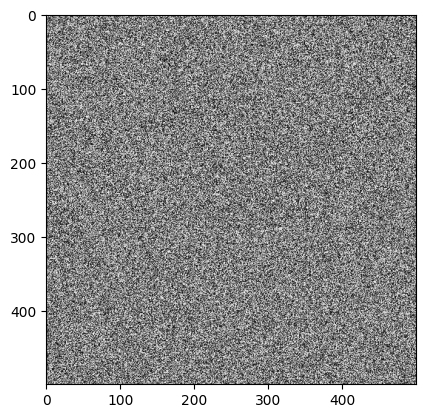

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a 224x224 array called 'pixel_array' with values ranging from 0 to 1
# pixel_array = np.random.rand(224, 224)  # Replace this with your actual array
for i in range(0,1):
  pixel_array = test

  # Create a figure and axes
  fig, ax = plt.subplots()

  # Plot the image with pixel values as colors
  ax.imshow(pixel_array, cmap='gray', vmin=0, vmax=1)

  # Hide the axis labels
  ax.axis('on')

  # Show the plot
  plt.show()


In [ ]:
np.dstack((croppedSlopeArrays[0],croppedElevationArrays[0]))[0][0][1]

32767

In [ ]:
y_train.shape

In [ ]:
x_train.shape

In [ ]:
print(x_test.shape)
print(y_test.shape)

In [ ]:
# Create two sample matrices
matrix1 = np.array([[1, 2], [3, 4]])
matrix2 = np.array([[5, 6], [7, 8]])

# Stack the matrices depth-wise using numpy.dstack()
merged_matrix = np.dstack((matrix1, matrix2))

# Print the merged matrix
print(merged_matrix)

# Resnet Architecture
There are 50 layers in total.

The layers are as follow:
1. InputLayer that accepts a tensor of shape `(224,224,3)` as input.
2. 7x7 Convolutional layer with 64 filters/kernels
3. Batch normalization layer.
4. ReLU activation layer.
5. 3x3 max pooling layer with a stride of 2.
6. Four groups of **residual blocks**, each containing several 3x3 convolutional layers, batch normalization layers, and ReLU activation layers.
7. A global average pooling layer.
8. A dense layer with 1000 units, followed by a softmax activation layer.

In [ ]:
resnet_model = keras.applications.ResNet50(
    weights=None,
    include_top=False
    )


resnet_model.trainable = False

In [ ]:
# Compile the model
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnet_model.summary()

In [ ]:
y_train.shape

In [ ]:
# train
resnet_model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10


ValueError: ignored

# Wind Influence Correction Probability


> Formula: $𝛺 =𝑠^{t}_{i,j}/𝑑$

Where $i,j$ is the cell with the fire.

> **Note:** We will have to calculate the $𝛺$ for every cell.

$s$ is given as follows

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-1wig{font-weight:bold;text-align:left;vertical-align:top}
.tg .tg-0lax{text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-1wig">Wind direction of cell(p,q)</th>
    <th class="tg-1wig">𝑺</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-0lax">Tail wind</td>
    <td class="tg-0lax">3.65𝑣 + 3.73</td>
  </tr>
  <tr>
    <td class="tg-0lax">Upwind</td>
    <td class="tg-0lax">−1.278𝑣</td>
  </tr>
  <tr>
    <td class="tg-0lax">Cross wind</td>
    <td class="tg-0lax">0.738𝑣 + 1.65</td>
  </tr>
  <tr>
    <td class="tg-0lax">Tail-cross wind</td>
    <td class="tg-0lax">(3.65𝑣 + 3.73) ⁄ √2</td>
  </tr>
  <tr>
    <td class="tg-0lax">Up-cross wind</td>
    <td class="tg-0lax">−1.278𝑣 ⁄ √2</td>
  </tr>
</tbody>
</table>


While $d$ is the center distance between the central cell and neighboring cells.